# Chapter1: Introduction

## Load a sample image and define the transformation

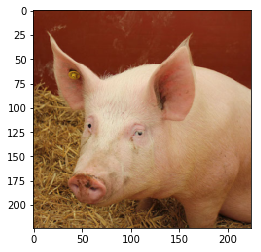

In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

# read the image, resize . to 225 and convert to Pytorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None, :, :, :]

plt.imshow(pig_tensor[0].numpy().transpose(1, 2, 0))

## Define the model and Normalization

In [3]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = resnet50(pretrained=True)
model.eval();

### Predict the label of the above pig image

In [4]:
pred = model(norm(pig_tensor))

In [5]:
import json 
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i, x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [6]:
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.0038814544677734375


## Creating an adversarial example

In [7]:
import torch.optim as optim
epsilon = 2. / 355
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = - nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
        
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0, 341].item())

0 -0.0038814544677734375
5 -0.0069332122802734375
10 -0.015836715698242188
15 -0.08089256286621094
20 -9.350421905517578
25 -9.928401947021484
True class probability: 3.607786857173778e-05


## Predicted Label for the pig image

In [8]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0, max_class].item())

Predicted class:  wombat
Predicted probability: 0.9996689558029175


## Pertubated Image

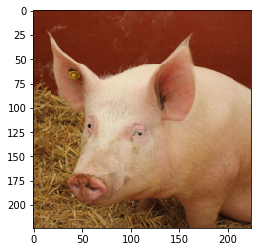

In [9]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))

## The noise pertubating the input image

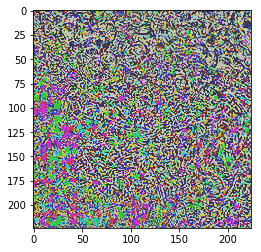

In [10]:
plt.imshow((50*delta + 0.5)[0].detach().numpy().transpose(1, 2, 0))

## Targetted Attacks
Targetted Attacks is to create the adversarial examples which is classified to the specified target class.

In [11]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (- nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.006052017211914
10 0.2430858612060547
20 -6.008253574371338
30 -11.645501136779785
40 -15.567898750305176
50 -17.892051696777344
60 -19.43048858642578
70 -21.8211669921875
80 -22.518007278442383
90 -24.243364334106445


In [12]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability: ", nn.Softmax(dim=1)(pred)[0, max_class].item())

Predicted class:  airliner
Predicted probability:  0.784337043762207


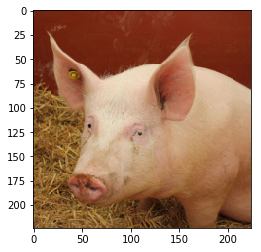

In [13]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))

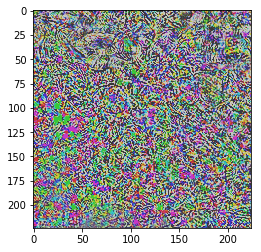

In [14]:
plt.imshow((50*delta + 0.5)[0].detach().numpy().transpose(1, 2, 0))

# Adversarial robustness and Training
### Traditional Risk of Machine Learning
TraditionalなRiskは，Training sampleのなかに含まれていないデータ（テストセットなど）を適切に分類できるかということであった．これはTrue distributionからサンプリングされているが，Training Sampleには含まれていない未知の点という意味．
### Adversarial Risk
True distributionからサンプリングされたサンプルではなく，それらの付近に存在する作り出されたサンプルに対して，正しく予測可能かという意味．
Traditional RiskよりもAdversarial Riskを考えることに必要性としては，人間はどんなに頑張っても，True Distributionからi.i.d.でサンプリングすることは不可能だからである．
人間がTrue Distibutionからサンプリングできていると思っても，結局のところ，人間の見える範囲の何らかのバイアスが発生していて，それに依存したサンプリングをすることしかできない．
だから結局のところCNNが人間の精度を超えたと言っても，それは特定のバイアスがかかったデータセットにおける分類タスクであって，明らかに豚である写真をそうと判断することができない限り，それは人間の識別性能を上回ったというのは過剰表現である．
これに対して，Adversarial Exampleｓは，fooling to classifiersするようにTuningされた画像であり，それは実世界のデータとはかけ離れているのではないかという意見もある．
一方で，TranslationやRotationするだけで，Adversarial Examplesを作り出すことも可能であることを考えると，実世界のデータでも起こりうる可能性がある．
また，人間にはバレない範囲で，データを加工することで，モデルを誤認識させることができるということを考えると，実応用上これは問題になる可能性がある．

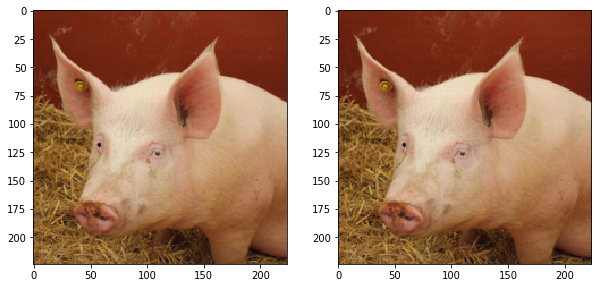

In [15]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

#### Training adversarially robust classifiers
Adversarial Examplesに対してロバストなモデルを作成する方法は，ただ単に，Adversarial Exampleを求める時の最適化式に対して，それのclassification lossを最小化するように目的関数を設定して学習することになる，
これは，min-max or robust optimizationと呼ばれる．
この時，AEのnoiseを決定するdeltaは，これから最適化されるモデルのパラメータΘに依存するが，そこの依存関係は無視して，定数として扱う．AEにロバストにするためのモデルのパラメータの変更によるdeltaの変化というのは，非常に微小量なので，無視しても問題ないため．
これは，Daskin's theoremと呼ばれている．
この証明は非常に難しいので，ここではその詳細には触れない．

## Final Comments

注意してほしいポイントとしては，全てのAdversarial Attack and Defenceは，それぞれInner miximization and/or Outer Minimization problemであるということ．